Ideas

- Visualize the map as sort of heatmap for every trip
    - focus on learning to use 'GIS'. Bind every trip to the nearest street or optimal route?
- average speed / distance per rideable_type
- speed by the:
    - season
    - incline
    - day time
    - distance

## Explore

In [4]:
import pandas as pd
import folium


In [5]:

df = pd.read_csv('bike_rent/202101-divvy-tripdata.csv')

# Convert the 'started_at' and 'ended_at' columns to datetime
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds()


MAX_LAT, MIN_LAT, MAX_LNG, MIN_LNG = (42.07, 41.64, -87.51, -87.81)

# Coordinates for the map center
MEAN_LAT = df.start_lat.mean()
MEAN_LNG = df.start_lng.mean()

In [68]:
# Remove by duration, keep from 1 minute to 1 hour
print(f"Initial number of rows: {len(df)}")
df = df[(df['duration'] >= 60) & (df['duration'] <= 1 * 3600)].reset_index(drop=True)
print(f"Number of rows after filtering: {len(df)}")

Initial number of rows: 96834
Number of rows after filtering: 93957


<Axes: >

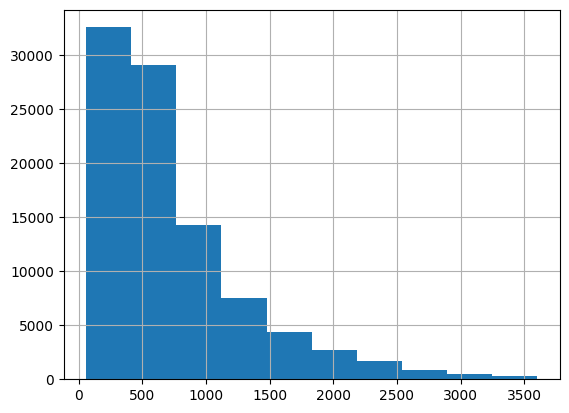

In [69]:
df.duration.hist()

In [70]:
len(df)

93957

In [71]:
df.head(2)

ride_id  rideable_type          started_at            ended_at  \
0  E19E6F1B8D4C42ED  electric_bike 2021-01-23 16:14:19 2021-01-23 16:24:44   
1  DC88F20C2C55F27F  electric_bike 2021-01-27 18:43:08 2021-01-27 18:47:12   

           start_station_name start_station_id end_station_name  \
0  California Ave & Cortez St            17660              NaN   
1  California Ave & Cortez St            17660              NaN   

  end_station_id  start_lat  start_lng  end_lat  end_lng member_casual  \
0            NaN  41.900341 -87.696743    41.89   -87.72        member   
1            NaN  41.900333 -87.696707    41.90   -87.69        member   

   duration  
0     625.0  
1     244.0

In [72]:
from pprint import pprint
pprint(df.head(1).to_json(orient='records'))

('[{"ride_id":"E19E6F1B8D4C42ED","rideable_type":"electric_bike","started_at":1611418459000,"ended_at":1611419084000,"start_station_name":"California '
 'Ave & Cortez '
 'St","start_station_id":"17660","end_station_name":null,"end_station_id":null,"start_lat":41.9003406667,"start_lng":-87.696743,"end_lat":41.89,"end_lng":-87.72,"member_casual":"member","duration":625.0}]')


In [73]:
df.rideable_type.value_counts()

rideable_type
classic_bike     60285
electric_bike    31915
docked_bike       1757
Name: count, dtype: int64

In [74]:
# For each station, count the number of trips that started or ended there

end_counts = df.end_station_name.value_counts()
start_counts = df.start_station_name.value_counts()

# Combine the counts into a single DataFrame
station_counts = pd.DataFrame({
    'start_count': start_counts,
    'end_count': end_counts
})

# Fill NaN values with 0
station_counts = station_counts.fillna(0)

# sum and sort
station_counts['total_count'] = station_counts['start_count'] + station_counts['end_count']
station_counts = station_counts.astype("int")
station_counts = station_counts.sort_values('total_count', ascending=False)

# Find coordinates for each station
stations = df[['start_station_name', 'start_lat', 'start_lng']].drop_duplicates("start_station_name")
stations = stations.rename(columns={
    'start_station_name': 'station_name',
    'start_lat': 'latitude',
    'start_lng': 'longitude'
})
# Merge counts with coordinates
station_counts = station_counts.merge(stations, left_index=True, right_on='station_name', how='right')

station_counts = station_counts[station_counts["total_count"] > 10].reset_index(drop=True)
station_counts.latitude.isna().sum()

np.int64(0)

In [75]:
station_counts

start_count  end_count  total_count                     station_name  \
0           87.0       88.0        175.0       California Ave & Cortez St   
1           40.0       36.0         76.0     Halsted St & North Branch St   
2           66.0       63.0        129.0         Glenwood Ave & Touhy Ave   
3          237.0      185.0        422.0            Michigan Ave & 8th St   
4          122.0       73.0        195.0                   Shedd Aquarium   
..           ...        ...          ...                              ...   
531         13.0       11.0         24.0              MLK Jr Dr & 47th St   
532        134.0      110.0        244.0  Blackstone Ave & Hyde Park Blvd   
533         23.0       28.0         51.0          Damen Ave & Pershing Rd   
534          6.0        6.0         12.0     Kilbourn Ave & Milwaukee Ave   
535         30.0       28.0         58.0        Cherry Ave & Blackhawk St   

      latitude  longitude  
0    41.900341 -87.696743  
1    41.899368 -87.648480  
2    42.012701 -87.666058  
3    41.872773 -87.623981  
4    41.867226 -87.615355  
..         ...        ...  
531  41.809851 -87.616279  
532  41.802562 -87.590368  
533  41.823191 -87.676644  
534  41.948801 -87.739958  
535  41.907221 -87.655618  

[536 rows x 6 columns]

### Max coords

In [76]:
df.head()

ride_id  rideable_type          started_at            ended_at  \
0  E19E6F1B8D4C42ED  electric_bike 2021-01-23 16:14:19 2021-01-23 16:24:44   
1  DC88F20C2C55F27F  electric_bike 2021-01-27 18:43:08 2021-01-27 18:47:12   
2  EC45C94683FE3F27  electric_bike 2021-01-21 22:35:54 2021-01-21 22:37:14   
3  4FA453A75AE377DB  electric_bike 2021-01-07 13:31:13 2021-01-07 13:42:55   
4  5D8969F88C773979  electric_bike 2021-01-09 14:24:07 2021-01-09 15:17:54   

           start_station_name start_station_id end_station_name  \
0  California Ave & Cortez St            17660              NaN   
1  California Ave & Cortez St            17660              NaN   
2  California Ave & Cortez St            17660              NaN   
3  California Ave & Cortez St            17660              NaN   
4  California Ave & Cortez St            17660              NaN   

  end_station_id  start_lat  start_lng  end_lat  end_lng member_casual  \
0            NaN  41.900341 -87.696743    41.89   -87.72        member   
1            NaN  41.900333 -87.696707    41.90   -87.69        member   
2            NaN  41.900313 -87.696643    41.90   -87.70        member   
3            NaN  41.900399 -87.696662    41.92   -87.69        member   
4            NaN  41.900409 -87.696763    41.94   -87.71        casual   

   duration  
0     625.0  
1     244.0  
2      80.0  
3     702.0  
4    3227.0

In [77]:
# Check the min and max latitude and longitude

max_lat = max([df['start_lat'].max(), df['end_lat'].max()])
min_lat = min([df['start_lat'].min(), df['end_lat'].min()])
max_lng = max([df['start_lng'].max(), df['end_lng'].max()])
min_lng = min([df['start_lng'].min(), df['end_lng'].min()])

# plot the polygon of the area with min and max coordinates
m = folium.Map(location=[MEAN_LAT, MEAN_LNG], zoom_start=12)

# Add a polygon to the map
folium.Polygon(
    locations=[
        [min_lat, min_lng],
        [min_lat, max_lng],
        [max_lat, max_lng],
        [max_lat, min_lng],
        [min_lat, min_lng]
    ],
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.1
).add_to(m)

In [ ]:
list(
    map(float, [max_lat, min_lat, max_lng, min_lng])
    )

MAX_LAT, MIN_LAT, MAX_LNG, MIN_LNG = (42.07, 41.64, -87.51, -87.81)

[42.07, 41.64, -87.51, -87.81]

In [78]:
m

<Axes: >

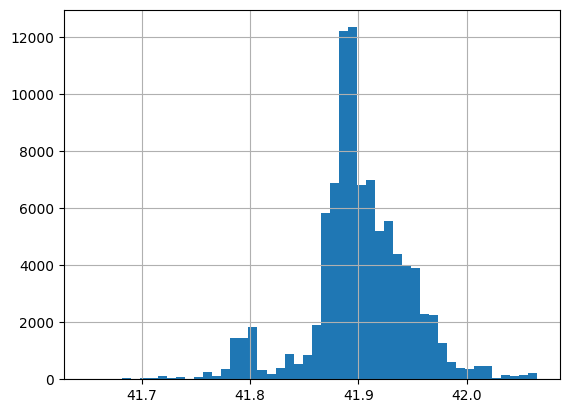

In [13]:
df.start_lat.round(4).hist(bins=50)

<Axes: >

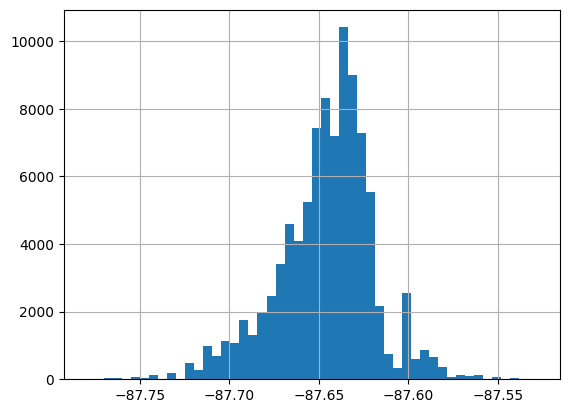

In [14]:
df.start_lng.round(4).hist(bins=50)

# Decide on size of the map

In [ ]:
lats = []
lons = []

for file in tqdm(files):
    # read
    df = pd.read_csv(f'{data_dir}/{file}')
    lats.extend(df['start_lat'].tolist())
    lats.extend(df['end_lat'].tolist())
    lons.extend(df['start_lng'].tolist())
    lons.extend(df['end_lng'].tolist())

  0%|          | 0/12 [00:00<?, ?it/s]

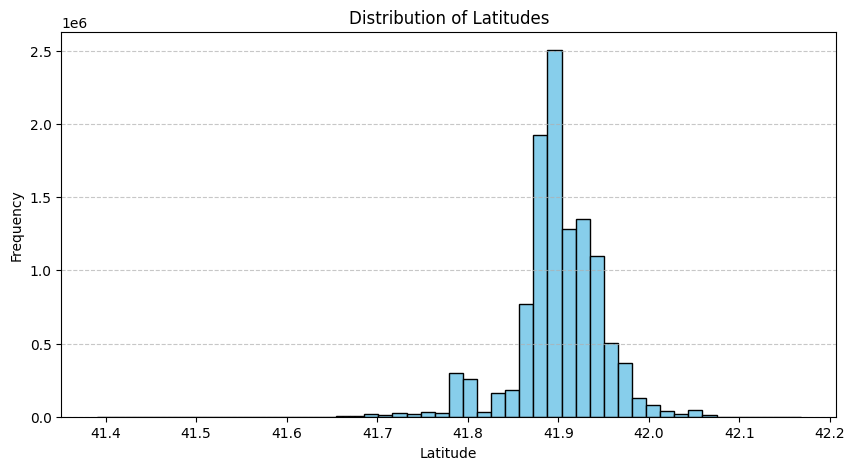

In [ ]:
# plot histogram of lats
plt.figure(figsize=(10, 5))
plt.hist(lats, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Latitudes')
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

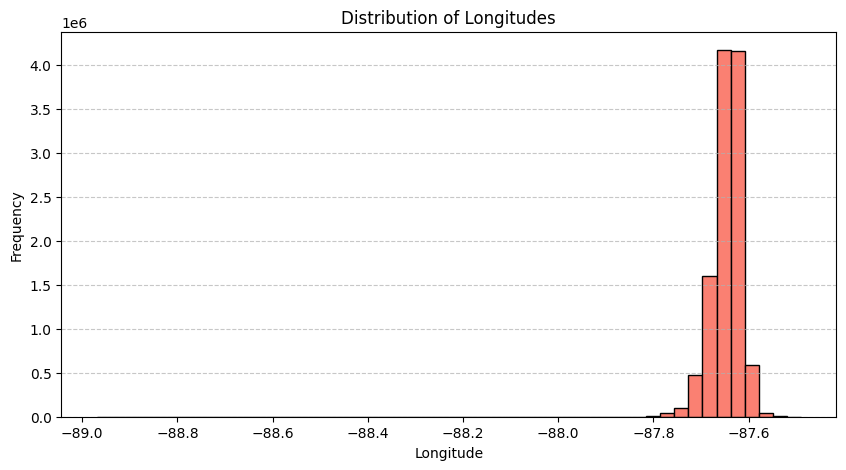

In [ ]:
# plot histogram of lats
plt.figure(figsize=(10, 5))
plt.hist(lons, bins=50, color='salmon', edgecolor='black')
plt.title('Distribution of Longitudes')
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# get the 5, and 95 percentiles of latitudes and longitudes
lat_5 = pd.Series(lats).quantile(0.05)
lat_95 = pd.Series(lats).quantile(0.95)
lon_5 = pd.Series(lons).quantile(0.05)
lon_95 = pd.Series(lons).quantile(0.95)
print(f"Latitude 5%: {lat_5}, 95%: {lat_95}")
print(f"Longitude 5%: {lon_5}, 95%: {lon_95}")

Latitude 5%: 41.8, 95%: 41.96909
Longitude 5%: -87.7, 95%: -87.6014497734


In [6]:
lat_5 = 41.8
lat_95 = 41.96909
lon_5 = -87.7
lon_95 = -87.6

In [8]:
# plot the polygon of the area with min and max coordinates
m = folium.Map(location=[MEAN_LAT, MEAN_LNG], zoom_start=12)

# Add a polygon to the map
folium.Polygon(
    locations=[
        [lat_5, lon_5],
        [lat_5, lon_95],
        [lat_95, lon_95],
        [lat_95, lon_5],
        [lat_5, lon_5]
    ],
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.1
).add_to(m)
m

### Check how much data points have stations

In [13]:
df.head()

ride_id  rideable_type          started_at            ended_at  \
0  E19E6F1B8D4C42ED  electric_bike 2021-01-23 16:14:19 2021-01-23 16:24:44   
1  DC88F20C2C55F27F  electric_bike 2021-01-27 18:43:08 2021-01-27 18:47:12   
2  EC45C94683FE3F27  electric_bike 2021-01-21 22:35:54 2021-01-21 22:37:14   
3  4FA453A75AE377DB  electric_bike 2021-01-07 13:31:13 2021-01-07 13:42:55   
4  BE5E8EB4E7263A0B  electric_bike 2021-01-23 02:24:02 2021-01-23 02:24:45   

           start_station_name start_station_id end_station_name  \
0  California Ave & Cortez St            17660              NaN   
1  California Ave & Cortez St            17660              NaN   
2  California Ave & Cortez St            17660              NaN   
3  California Ave & Cortez St            17660              NaN   
4  California Ave & Cortez St            17660              NaN   

  end_station_id  start_lat  start_lng  end_lat  end_lng member_casual  \
0            NaN  41.900341 -87.696743    41.89   -87.72        member   
1            NaN  41.900333 -87.696707    41.90   -87.69        member   
2            NaN  41.900313 -87.696643    41.90   -87.70        member   
3            NaN  41.900399 -87.696662    41.92   -87.69        member   
4            NaN  41.900326 -87.696697    41.90   -87.70        casual   

   duration  
0     625.0  
1     244.0  
2      80.0  
3     702.0  
4      43.0

In [16]:
# Count station number where start or end station is null
null_stations = df[(df['start_station_name'].isnull()) | (df['end_station_name'].isnull())]
print(f"Number of trips with null start or end station: {len(null_stations)}")

print(f"Which is the percentage of trips with null start or end station: {len(null_stations) / len(df) * 100:.2f}%")

Number of trips with null start or end station: 12446
Which is the percentage of trips with null start or end station: 13.25%


## Check folium map

In [17]:

m = folium.Map(location=[df.start_lat.mean(), df.start_lng.mean()], zoom_start=11)

def draw_line(row):
    folium.PolyLine(
        locations=[[row.start_lat, row.start_lng], [row.end_lat, row.end_lng]],
        color='blue',
        weight=1,
        opacity=0.5
    ).add_to(m)

for _, row in df.head(5000).iterrows():
    draw_line(row)

def draw_station(row):
    folium.Marker(
        location=[row.latitude, row.longitude],
        popup=f"{row.station_name} ({row.total_count})",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

for _, row in station_counts.iterrows():
    draw_station(row)


In [18]:
m

In [19]:
df.head()

ride_id  rideable_type          started_at            ended_at  \
0  E19E6F1B8D4C42ED  electric_bike 2021-01-23 16:14:19 2021-01-23 16:24:44   
1  DC88F20C2C55F27F  electric_bike 2021-01-27 18:43:08 2021-01-27 18:47:12   
2  EC45C94683FE3F27  electric_bike 2021-01-21 22:35:54 2021-01-21 22:37:14   
3  4FA453A75AE377DB  electric_bike 2021-01-07 13:31:13 2021-01-07 13:42:55   
4  5D8969F88C773979  electric_bike 2021-01-09 14:24:07 2021-01-09 15:17:54   

           start_station_name start_station_id end_station_name  \
0  California Ave & Cortez St            17660              NaN   
1  California Ave & Cortez St            17660              NaN   
2  California Ave & Cortez St            17660              NaN   
3  California Ave & Cortez St            17660              NaN   
4  California Ave & Cortez St            17660              NaN   

  end_station_id  start_lat  start_lng  end_lat  end_lng member_casual  \
0            NaN  41.900341 -87.696743    41.89   -87.72        member   
1            NaN  41.900333 -87.696707    41.90   -87.69        member   
2            NaN  41.900313 -87.696643    41.90   -87.70        member   
3            NaN  41.900399 -87.696662    41.92   -87.69        member   
4            NaN  41.900409 -87.696763    41.94   -87.71        casual   

   duration  
0     625.0  
1     244.0  
2      80.0  
3     702.0  
4    3227.0

## Take one station and vizualize all start and end points of it

In [26]:
# Take one station and vizualize all start and end points of it

station_name = "Halsted St & North Branch St"

starts = df[df.start_station_name == station_name].reset_index()
starts = starts.rename(columns = {"start_lat": "latitude", "start_lng": "longitude"})
ends = df[df.end_station_name == station_name].reset_index()
ends = ends.rename(columns = {"end_lat": "latitude", "end_lng": "longitude"})

m = folium.Map(location=[MEAN_LAT, MEAN_LNG], zoom_start=20)

def draw_station(row):
    folium.Marker(
        location=[row.latitude, row.longitude],
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

for _, row in starts.iterrows():
    draw_station(row)
    
def draw_station(row):
    folium.Marker(
        location=[row.latitude, row.longitude],
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

for _, row in ends.iterrows():
    draw_station(row)

In [27]:
m

## Test osmnx

In [10]:
import osmnx as ox, networkx as nx

# 1) download/trim street network around Chicago
# G = ox.graph_from_point((41.895, -87.705), dist=5000, network_type="bike")

In [2]:
def coords_to_path(start_lat, start_lng, end_lat, end_lng):
    """
    Convert start and end coordinates to a path of coordinates.
    """
    # snap start/end points to nearest nodes
    orig = ox.nearest_nodes(G, start_lng, start_lat)
    dest = ox.nearest_nodes(G, end_lng, end_lat)

    # shortest path by distance
    path_nodes = nx.shortest_path(G, orig, dest, weight="length")
    path_coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path_nodes]
    
    return path_coords

In [91]:
# path_coords = coords_to_path(41.895, -87.705, 41.9, -87.7)

# m = folium.Map(location=[df.start_lat.mean(), df.start_lng.mean()], zoom_start=11)

# # Draw path
# folium.PolyLine(
#     locations=path_coords,
#     color='red',
#     weight=5,
#     opacity=0.8
# ).add_to(m)

## Show osmnx paths on the map

In [12]:
df

ride_id  rideable_type          started_at  \
0      E19E6F1B8D4C42ED  electric_bike 2021-01-23 16:14:19   
1      DC88F20C2C55F27F  electric_bike 2021-01-27 18:43:08   
2      EC45C94683FE3F27  electric_bike 2021-01-21 22:35:54   
3      4FA453A75AE377DB  electric_bike 2021-01-07 13:31:13   
4      BE5E8EB4E7263A0B  electric_bike 2021-01-23 02:24:02   
...                 ...            ...                 ...   
96829  B1A5336E1412D8BF   classic_bike 2021-01-19 19:03:17   
96830  57EA5CB7DCD75F90   classic_bike 2021-01-05 18:42:27   
96831  815B319A078CC984   classic_bike 2021-01-07 17:59:47   
96832  6DB04151565CEE63   classic_bike 2021-01-06 19:20:31   
96833  8008C9C998083A1A    docked_bike 2021-01-17 13:20:02   

                 ended_at               start_station_name start_station_id  \
0     2021-01-23 16:24:44       California Ave & Cortez St            17660   
1     2021-01-27 18:47:12       California Ave & Cortez St            17660   
2     2021-01-21 22:37:14       California Ave & Cortez St            17660   
3     2021-01-07 13:42:55       California Ave & Cortez St            17660   
4     2021-01-23 02:24:45       California Ave & Cortez St            17660   
...                   ...                              ...              ...   
96829 2021-01-19 20:10:03        Lake Shore Dr & Monroe St            13300   
96830 2021-01-05 19:33:33        Lake Shore Dr & Monroe St            13300   
96831 2021-01-07 19:34:03  Lakefront Trail & Bryn Mawr Ave     KA1504000152   
96832 2021-01-06 20:41:57  Lakefront Trail & Bryn Mawr Ave     KA1504000152   
96833 2021-01-17 14:17:00        Lake Shore Dr & Monroe St            13300   

                      end_station_name end_station_id  start_lat  start_lng  \
0                                  NaN            NaN  41.900341 -87.696743   
1                                  NaN            NaN  41.900333 -87.696707   
2                                  NaN            NaN  41.900313 -87.696643   
3                                  NaN            NaN  41.900399 -87.696662   
4                                  NaN            NaN  41.900326 -87.696697   
...                                ...            ...        ...        ...   
96829  Lakefront Trail & Bryn Mawr Ave   KA1504000152  41.880958 -87.616743   
96830  Lakefront Trail & Bryn Mawr Ave   KA1504000152  41.880958 -87.616743   
96831  Lakefront Trail & Bryn Mawr Ave   KA1504000152  41.984037 -87.652310   
96832  Lakefront Trail & Bryn Mawr Ave   KA1504000152  41.984037 -87.652310   
96833        Lake Shore Dr & Monroe St          13300  41.880958 -87.616743   

         end_lat    end_lng member_casual  duration  
0      41.890000 -87.720000        member     625.0  
1      41.900000 -87.690000        member     244.0  
2      41.900000 -87.700000        member      80.0  
3      41.920000 -87.690000        member     702.0  
4      41.900000 -87.700000        casual      43.0  
...          ...        ...           ...       ...  
96829  41.984037 -87.652310        member    4006.0  
96830  41.984037 -87.652310        member    3066.0  
96831  41.984037 -87.652310        member    5656.0  
96832  41.984037 -87.652310        member    4886.0  
96833  41.880958 -87.616743        casual    3418.0  

[96834 rows x 14 columns]

In [11]:

# make bbox (tuple[float, float, float, float]) – Bounding box as (left, bottom, right, top). Coordinates should be in unprojected latitude-longitude degrees (EPSG:4326)

# MIN_LNG, MIN_LAT, MAX_LNG, MAX_LAT = (-87.81, 41.64, -87.51, 42.07)
MIN_LNG, MIN_LAT, MAX_LNG, MAX_LAT = lon_5, lat_5, lon_95, lat_95
bbox = (MIN_LNG, MIN_LAT, MAX_LNG, MAX_LAT)

G = ox.graph_from_bbox(bbox, network_type="all_public")

In [106]:
# assign speeds constant speed to all edges
nx.set_edge_attributes(G, values=10, name="speed_kph")

# convert length+speed → seconds
G = ox.add_edge_travel_times(G)

In [109]:

ox.save_graphml(G, "all_public_bbox.graphml")


In [110]:
G = ox.load_graphml("all_public_bbox.graphml")

In [111]:
def coords_to_path(start_lat, start_lng, end_lat, end_lng):
    """
    Convert start and end coordinates to a path of coordinates.
    """
    # snap start/end points to nearest nodes
    orig = ox.nearest_nodes(G, start_lng, start_lat)
    dest = ox.nearest_nodes(G, end_lng, end_lat)

    # shortest path by distance
    try:
        path_nodes = nx.shortest_path(G, orig, dest, weight="distance")
    except nx.NetworkXNoPath:
        print(f"No path found between {orig} and {dest}.")
        return []
    path_coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path_nodes]
    
    return path_coords

In [ ]:
# start_lat                            41.795212
# start_lng                           -87.580715
# end_lat                              41.791478
# end_lng                             -87.599861

start = (41.795212, -87.580715)
end = (41.791478, -87.599861)

# start_lat                            41.877945
# start_lng                           -87.662007
# end_lat                              41.865234
# end_lng                             -87.666507

# start = (41.877, -87.662)
# end = (41.865, -87.666)

m = folium.Map(location=start, zoom_start=12)
path_coords = coords_to_path(start[0], start[1], end[0], end[1])

folium.PolyLine(
    locations=path_coords,
    color='red',
    weight=5,
    opacity=0.8
).add_to(m)
# Add start and end points
folium.Marker(
    location=start,
    popup='Start',
    icon=folium.Icon(color='green', icon='info-sign')
).add_to(m)
folium.Marker(
    location=end,
    popup='End',
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m)
m

: 

In [ ]:
# 1.43 ir 2sec

In [27]:
m = folium.Map(location=[df.start_lat.mean(), df.start_lng.mean()], zoom_start=11)

for _, row in df.head(100).iterrows():
    path_coords = coords_to_path(row.start_lat, row.start_lng, row.end_lat, row.end_lng)
    if path_coords:
        folium.PolyLine(
            locations=path_coords,
            color='blue',
            weight=1,
        ).add_to(m)

In [28]:
m

In [26]:
import osmnx as ox, networkx as nx

# build a bike network for the whole city
# G = ox.graph_from_place("Chicago, USA", network_type="bike")

# Or download/trim street network around Chicago
MEAN_LAT = df.start_lat.mean()
MEAN_LNG = df.start_lng.mean()
G = ox.graph_from_point((MEAN_LAT, MEAN_LNG), dist=5000, network_type="bike")

In [41]:
test = df.iloc[0]
start_lat = test.start_lat
start_lng = test.start_lng
end_lat = test.end_lat
end_lng = test.end_lng

'2021-01-23 16:14:19'

In [ ]:
# 1) assign speeds (kph).  Use your own dict if you prefer a constant bike speed.
G = ox.add_edge_speeds(G, hwy_speeds={"cycleway":18, "path":14})  # falls back to 15 km/h elsewhere

# 2) convert length+speed → seconds
G = ox.add_edge_travel_times(G)   # adds edge attr “travel_time” :contentReference[oaicite:0]{index=0}

AttributeError: module 'osmnx' has no attribute 'utils_graph'

In [34]:
import osmnx as ox
import networkx as nx
from datetime import timedelta


# The place where your 2 points are located. It will be used to create a graph from the OSM data
# In this example, the 2 points are two addresses in Manhattan, so we choose "Manhattan"
# It could be a bounding box too, or an area around a point
# graph_area = ("Manhattan, New York, USA")

# Create the graph of the area from OSM data. It will download the data and create the graph
# G = ox.graph_from_place(graph_area, network_type='drive')
# (For a better accuracy, create a graph with lot more nodes:)
#G = ox.graph_from_place(graph_area, network_type='drive', simplify=False)

# OSM data are sometime incomplete so we use the speed module of osmnx to add missing edge speeds and travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)


In [35]:

# Save graph to disk if you want to reuse it
ox.save_graphml(G, "my_graph.graphml")



In [ ]:
# Load the graph
G = ox.load_graphml("my_graph.graphml")

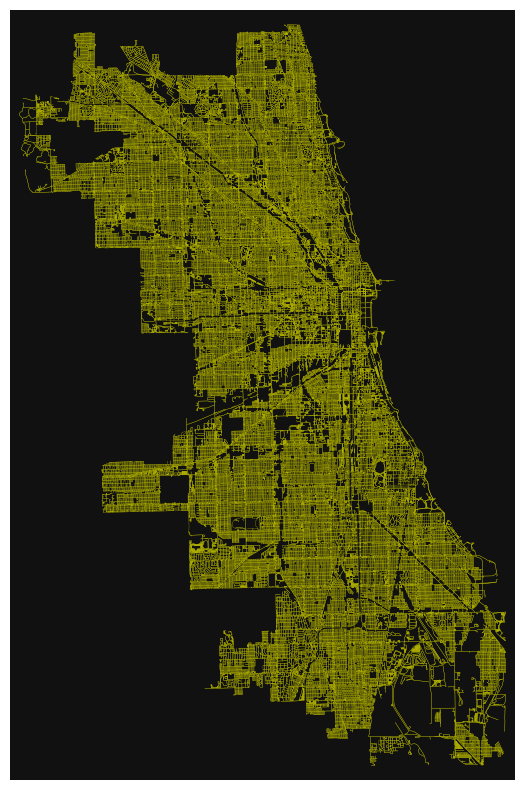

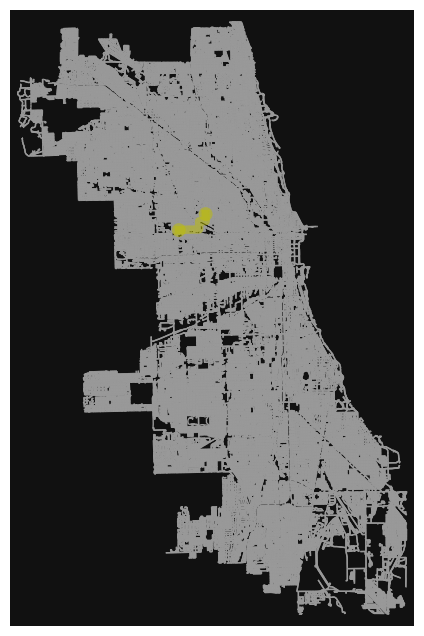

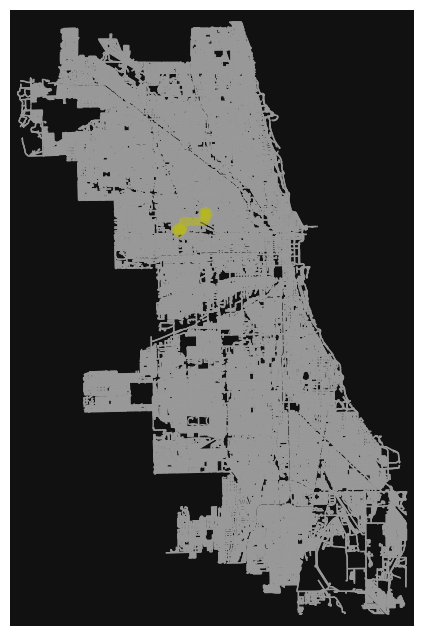

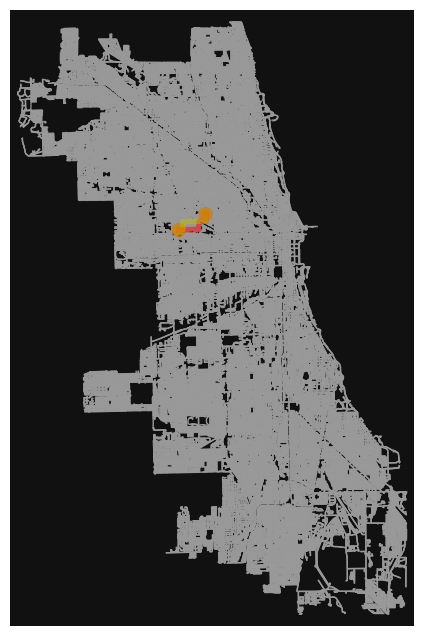

travel time in seconds 250.16342991971896
travel time in hours minutes seconds 0:04:10.163430
distance in meters 3021.626957223508
distance in kilometers 3.021626957223508


In [36]:


# Plot the graph
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color='y', edge_linewidth=0.2)

# Two pairs of (lat,lng) coordinates
origin_coordinates = (start_lat, start_lng) 
destination_coordinates = (end_lat, end_lng)

# In the graph, get the nodes closest to the points
origin_node = ox.nearest_nodes(G, Y=origin_coordinates[0], X=origin_coordinates[1])
destination_node = ox.nearest_nodes(G, Y=destination_coordinates[0], X=destination_coordinates[1])


# Get the shortest route by distance
shortest_route_by_distance = ox.shortest_path(G, origin_node, destination_node, weight='length')

# Plot the shortest route by distance
fig, ax = ox.plot_graph_route(G, shortest_route_by_distance, route_color='y', route_linewidth=6, node_size=0)

# Get the shortest route by travel time
shortest_route_by_travel_time = ox.shortest_path(G, origin_node, destination_node, weight='travel_time')

# Plot the shortest route by travel time
fig, ax = ox.plot_graph_route(G, shortest_route_by_travel_time, route_color='y', route_linewidth=6, node_size=0)

# Plot the 2 routes
fig, ax = ox.plot_graph_routes(G, routes=[shortest_route_by_distance, shortest_route_by_travel_time], route_colors=['r', 'y'], route_linewidth=6, node_size=0)

# Get the travel time, in seconds
# Note here that we use "nx" (networkx), not "ox" (osmnx)
travel_time_in_seconds = nx.shortest_path_length(G, origin_node, destination_node, weight='travel_time')
print("travel time in seconds", travel_time_in_seconds)

#The travel time in "HOURS:MINUTES:SECONDS" format
travel_time_in_hours_minutes_seconds = str(timedelta(seconds=travel_time_in_seconds))
print("travel time in hours minutes seconds", travel_time_in_hours_minutes_seconds)

# Get the distance in meters
distance_in_meters = nx.shortest_path_length(G, origin_node, destination_node, weight='length')
print("distance in meters", distance_in_meters)
# Distance in kilometers
distance_in_kilometers = distance_in_meters / 1000
print("distance in kilometers", distance_in_kilometers)

In [ ]:
# Compute the shortest route by travel time
route = nx.shortest_path(G, origin_node, destination_node, weight='travel_time')

# Convert the route to a GeoDataFrame
route_gdf = ox.routing.route_to_gdf(G, route)

# Calculate total travel time and distance
total_travel_time = route_gdf['travel_time'].sum()  # in seconds
total_distance = route_gdf['length'].sum()  # in meters

print(f"Total travel time: {total_travel_time / 60:.2f} minutes")
print(f"Total distance: {total_distance / 1000:.2f} kilometers")

Total travel time: 4.17 minutes
Total distance: 3.03 kilometers
